HEARTBEAT_SOUNDS:
Heart sounds are produced from a
specific cardiac event such as closure of
a valve or tensing of a chordae
tendineae.

• S1 result from the closing of the mitral
and tricuspid valves.

• S2 produced by the closure of the aortic
and pulmonic valves.

In medicine we call the ‘lub’
sound "S1" and the ‘dub’ sound
"S2".

ABOUT THE DATA:
Is challenge published in 2012 to classify the heart sound to some categories from ‘AISTATS’ .
Data has been gathered from two sources (A) and (B).

A) from the general public via the iStethoscope Pro.

B) from a clinic trial in hospitals using the digital stethoscope DigiScope.


Imorting required things

In [2]:
import os#to fetch data
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa#to deal with audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

#deep learning things
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv1D,Conv2D,MaxPooling2D,SeparableConv1D
from tensorflow.keras.layers import Input,add,Flatten,Dense,BatchNormalization,Dropout,LSTM,GRU
from tensorflow.keras.layers import GlobalMaxPooling1D,GlobalMaxPooling2D,Activation,ReLU,LeakyReLU

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report


c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Data Loading

In [5]:
data_path ="./Heartbeat_Sound"
print(os.listdir(data_path))

['artifact', 'extrahls', 'extrastole', 'murmur', 'normal', 'unlabel']


In [6]:
train_data      = data_path
unlabel_data    = data_path  + "/unlabel/"

normal_data     = train_data + '/normal/'
murmur_data     = train_data + '/murmur/'
extrastole_data = train_data + '/extrastole/'
artifact_data   = train_data + '/artifact/'
extrahls_data   = train_data + "/extrahls/"

In [7]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("Murmur files:",len(os.listdir(murmur_data))) #length of murmur training sounds
print("Extrastole files", len(os.listdir(extrastole_data))) #length of extrastole training sounds
print("Artifact files:",len(os.listdir(artifact_data))) #length of artifact training sounds
print("Extrahls files:",len(os.listdir(extrahls_data))) #length of extrahls training sounds

print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data))
                              + len(os.listdir(murmur_data))
                              + len(os.listdir(extrastole_data))
                              + len(os.listdir(artifact_data))
                              + len(os.listdir(extrahls_data)))

Normal files: 351
Murmur files: 129
Extrastole files 46
Artifact files: 40
Extrahls files: 19
TOTAL TRAIN SOUNDS: 585


In [8]:
print("Test sounds: ", len(os.listdir(unlabel_data)))

Test sounds:  247


**EDA**-Exploratory Data Analysis

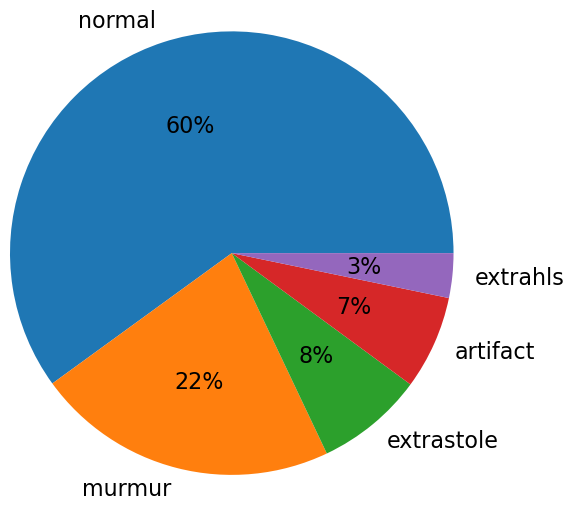

In [9]:
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(murmur_data)),
              len(os.listdir(extrastole_data)),
              len(os.listdir(artifact_data)),
              len(os.listdir(extrahls_data))])
labels = ['normal', 'murmur', 'extrastole', 'artifact', 'extrahls']
plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show()

The figure shows imbalanced data

In [10]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class)))
    sound = os.listdir(audio_class)[random_sound]
    sound = audio_class+sound
    sound,sample_rate = librosa.load(sound)
    return ipd.Audio(sound,rate=sample_rate),sound

WAVEFORM:

Sound is the pressure of air propagates to our ear. Digital audio file is gotten from a sound sensor that can detects sound waves and converting it to electrical signals.
Specifically, it's telling us about the wave's displacement, and how it changes over time.

X axis, represents time.
Y-axis measures displacement of air molecules.This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  

In [11]:
# show waveform of audio from dataset
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))
    librosa.display.waveshow(audio_sample, sr=22050)
    plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

SPECTRUM:

A sound spectrum is a representation of a sound – usually a short sample of a sound – in terms of the amount of vibration at each individual frequency. It is usually presented as a graph of either power or pressure as a function of frequency. The power or pressure is usually measured in decibels and the frequency is measured in vibrations per second (or hertz, abbreviation Hz) or thousands of vibrations per second (kilohertz, abbreviation kHz).

The spectrum expresses the frequency composition of the sound and is obtained by analyzing the sound. A sound spectrum is usually represented in a coordinate plane where the frequency f is plotted along the axis of abscissas and the amplitude A, or intensity, of a harmonic component with a given frequency is plotted along the axis of ordinates.

In [12]:
# show spectrum of audio from dataset
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)
    magnitude_normal = np.abs(fft_normal)
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal))
    half_freq = freq_normal[:int(len(freq_normal)/2)]
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

    plt.figure(figsize=(12,8))
    plt.plot(half_freq,half_magnitude)
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

SPECTOGRAM:

For us, as human, we sense a sound not only on a particular time by its intensity, but also by its pitch. The pitch is the frequency of the sound - higher pitch corresponding to higher frequency and vice versa. So, to have a representation which is closer to our brain, we can add another dimension - the frequency - to our representation, which is the Spectrogram.

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

Spectrograms are used extensively in the fields of music, linguistics, sonar, radar, speech processing,seismology, and others. Spectrograms of audio can be used to identify spoken words phonetically, and to analyse the various calls of animals.it can be generated by an optical spectrometer, a bank of band-pass filters, by Fourier transform or by a wavelet transform.

In [13]:
# show specrogram of audio from dataset
# the output is an image that represents a sound.
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate
    n_fft_duration = float(n_fft)/sample_rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

MFCC:

We can’t take the raw audio signal as input to our model because there will be a lot of noise in the audio signal. It is observed that extracting features from the audio signal and using it as input to the base model will produce much better performance than directly considering raw audio signal as input. MFCC is the widely used technique for extracting the features from the audio signal.

in sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

**MFCCs are commonly derived as follows:**

1- Take the Fourier transform of (a windowed excerpt of) a signal.

2- Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows or alternatively, cosine overlapping windows.

3- Take the logs of the powers at each of the mel frequencies.

4- Take the discrete cosine transform of the list of mel log powers, as if it were a signal.

5- The MFCCs are the amplitudes of the resulting spectrum.

In [14]:
# MFCCs
# extract 52 MFCCs
def show_mfcc_features(audio_sample):
    hop_length = 512
    n_fft = 2048
    sample_rate = 22050

    MFCCs = librosa.feature.mfcc(
        y=audio_sample,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mfcc=52   # 52 features
    )

    plt.figure(figsize=(15,10))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title("MFCCs")
    plt.show()

Dataset Classes

1. Normal
<br>
most normal heart rates will be between about 60 and 100 beats per minute

In [15]:


normal_audio, normal_sample= random_sound(normal_data)
normal_audio

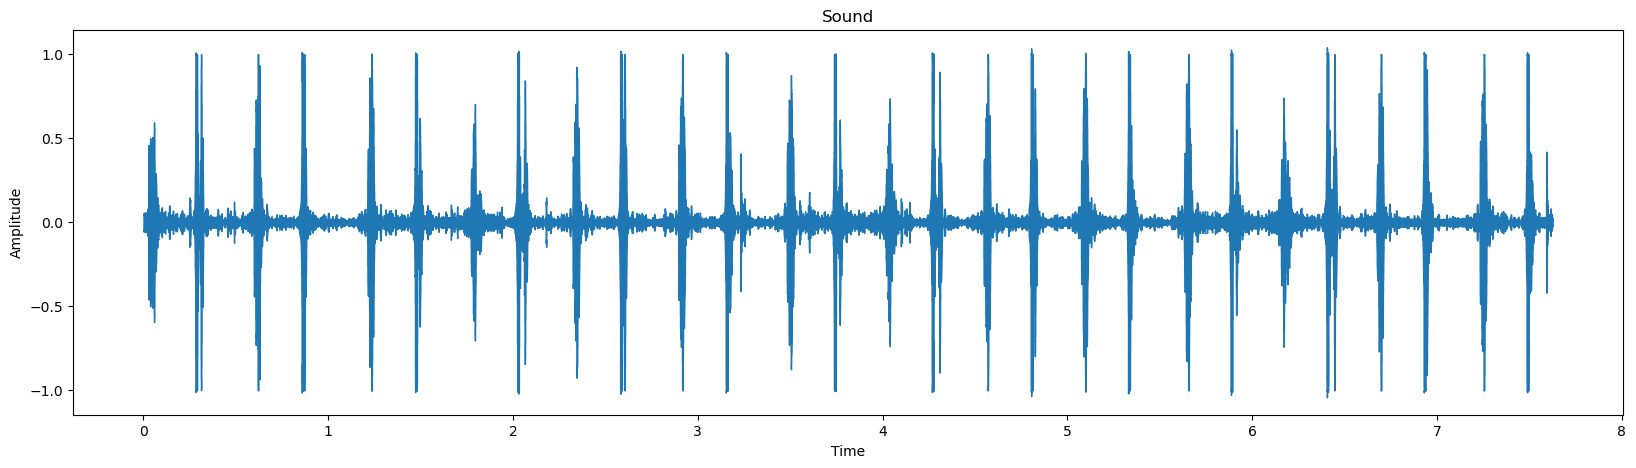

In [16]:
show_audio_waveform(normal_sample)

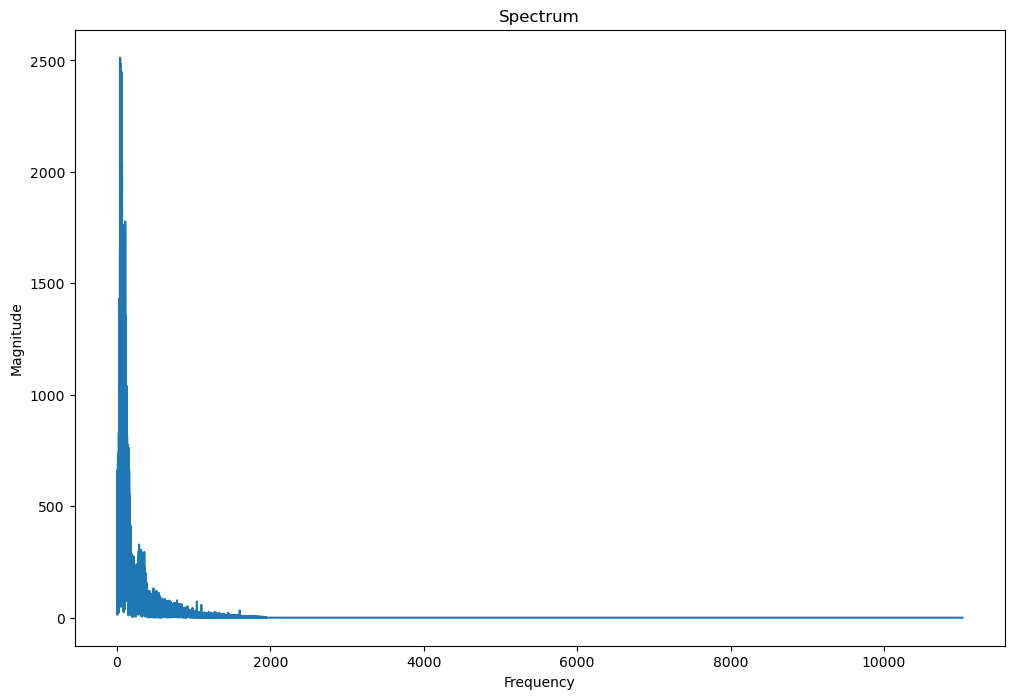

In [17]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


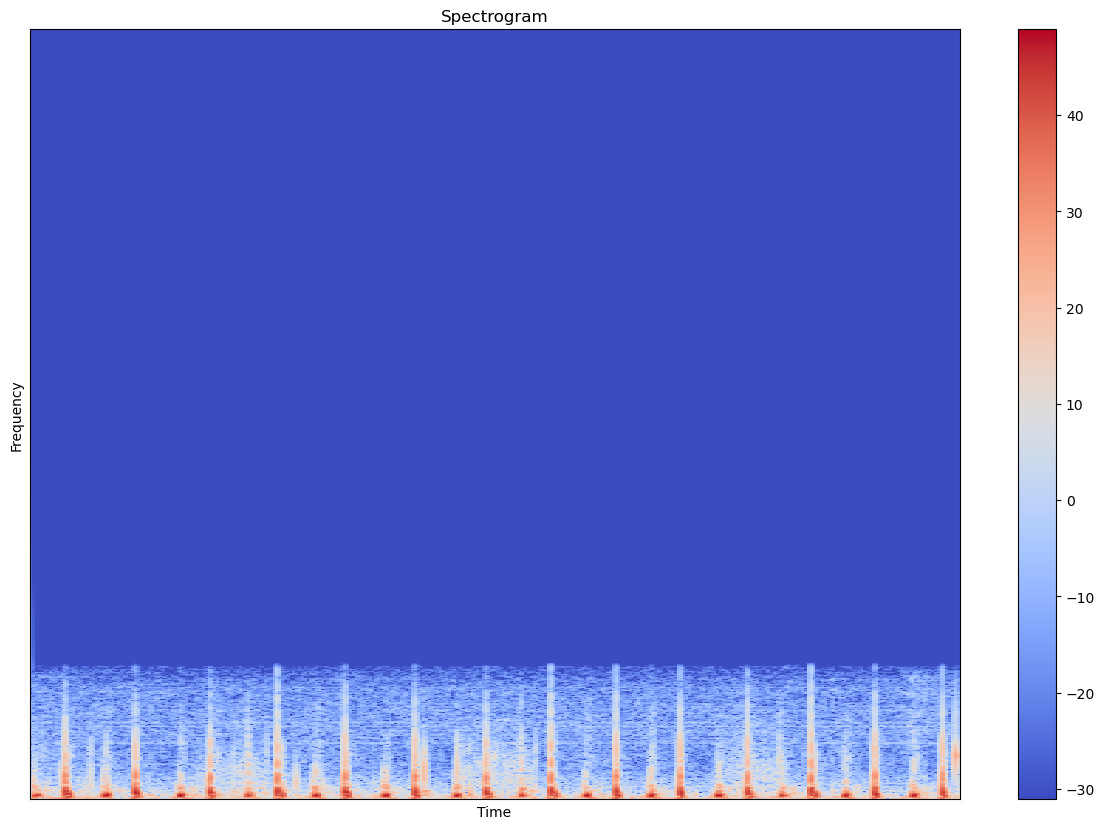

In [18]:
show_spectrogram(normal_sample)

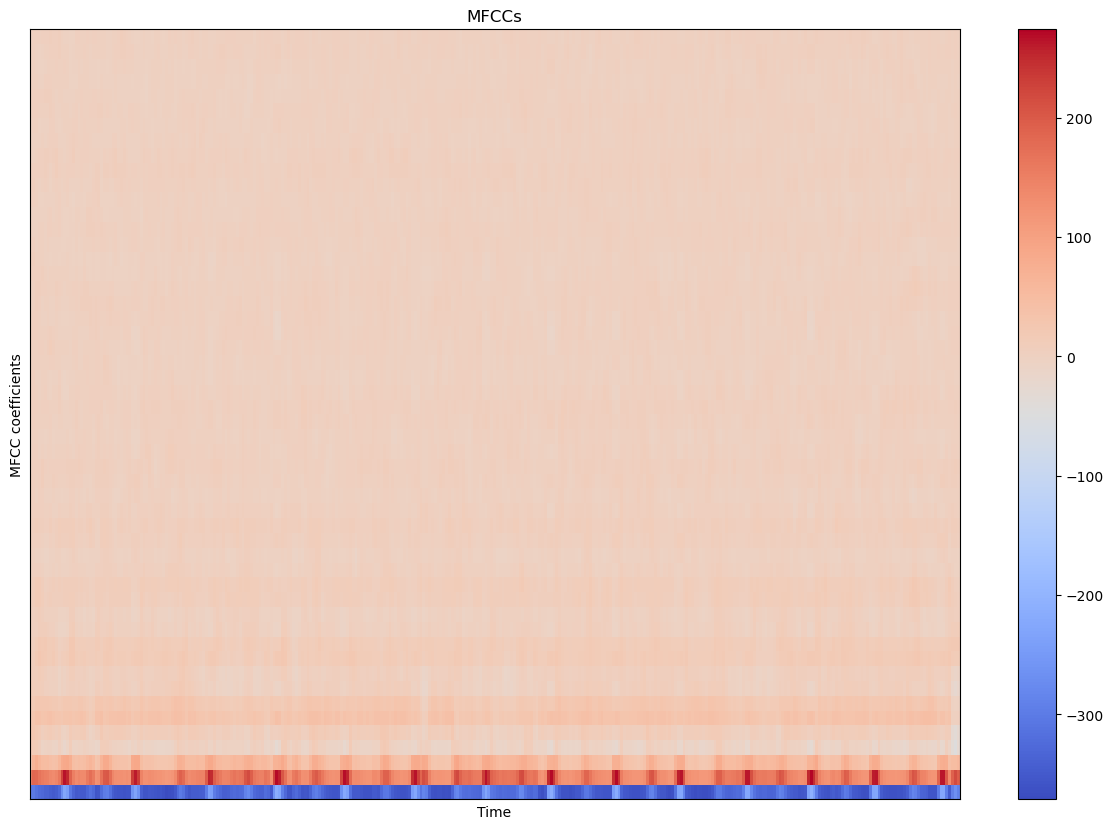

In [19]:
show_mfcc_features(normal_sample)

2. Murmur sound

Heart murmurs sound as though there
is a “whooshing, roaring, rumbling, or
turbulent fluid” noise in one of two
temporal locations: (1) between “lub”
and “dub”, or (2) between “dub” and
“lub”. They can be a symptom of many
heart disorders, some serious.

In [20]:
murmur_audio, murmur_sample  = random_sound(murmur_data)
murmur_audio

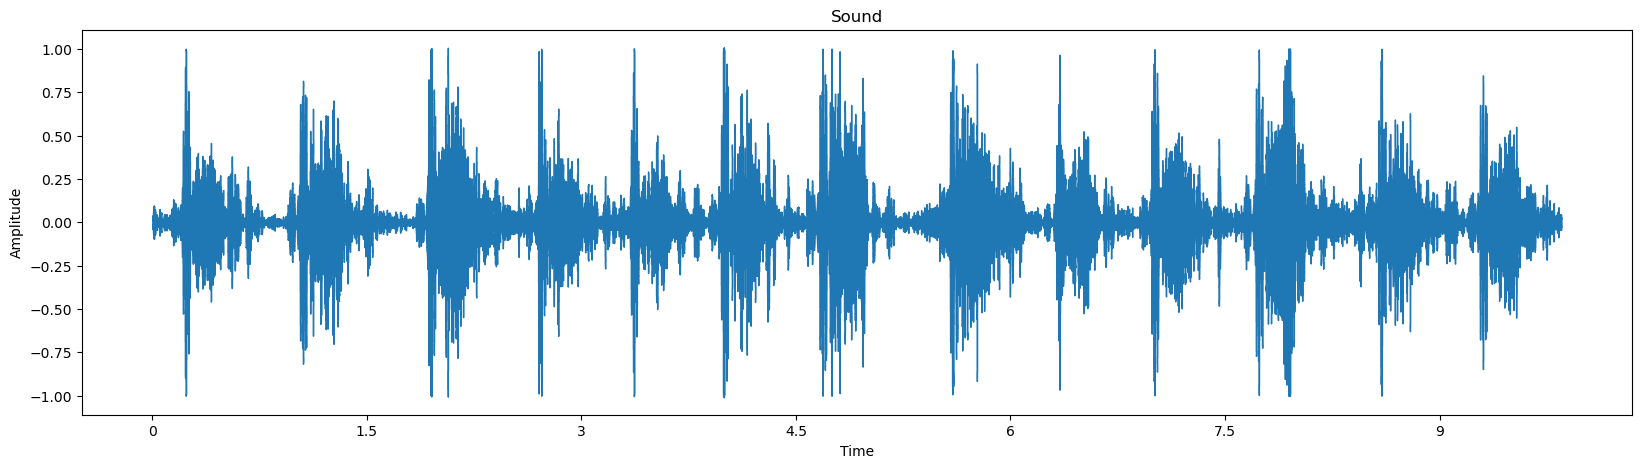

In [21]:
show_audio_waveform(murmur_sample)

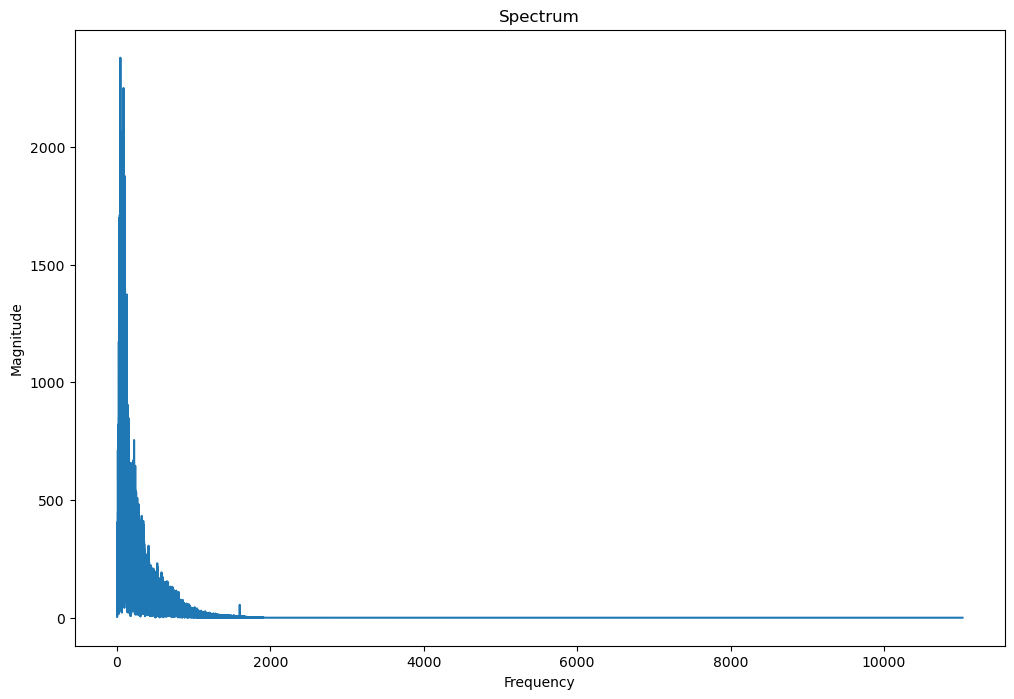

In [22]:
show_audio_spectrum(murmur_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


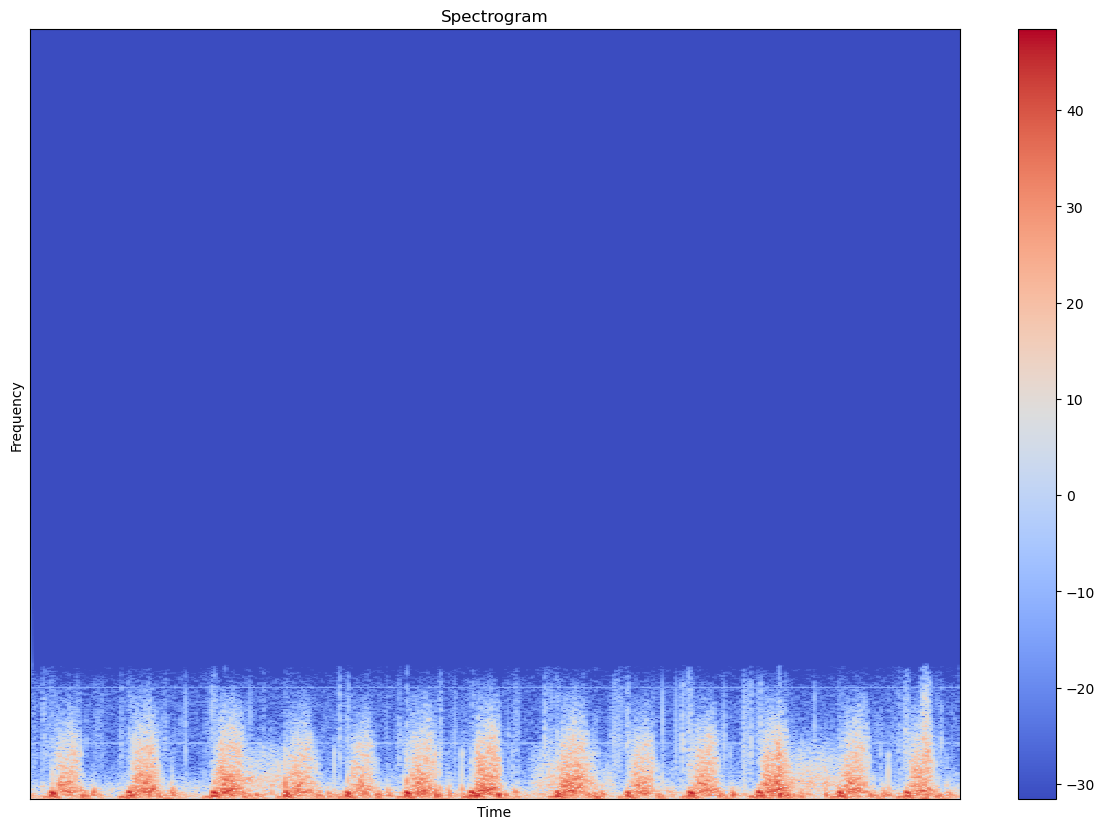

In [23]:
show_spectrogram(murmur_sample)

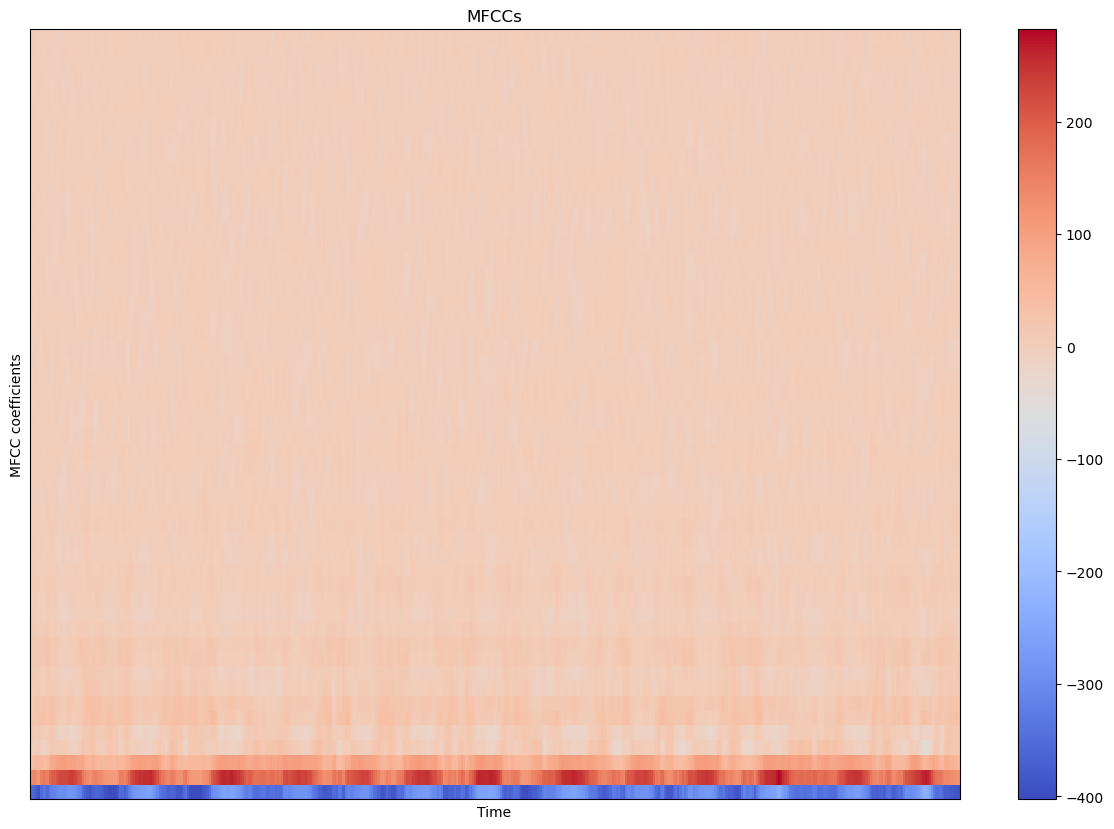

In [24]:
show_mfcc_features(murmur_sample)

3. Extrastole sound


• Extrasystole sounds may appear occasionally and can be
identified because there is a heart sound that is out of rhythm
involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a
“lub dub-dub”.

In [25]:
extrastole_audio,extrastole_sample=random_sound(extrastole_data)
extrastole_audio

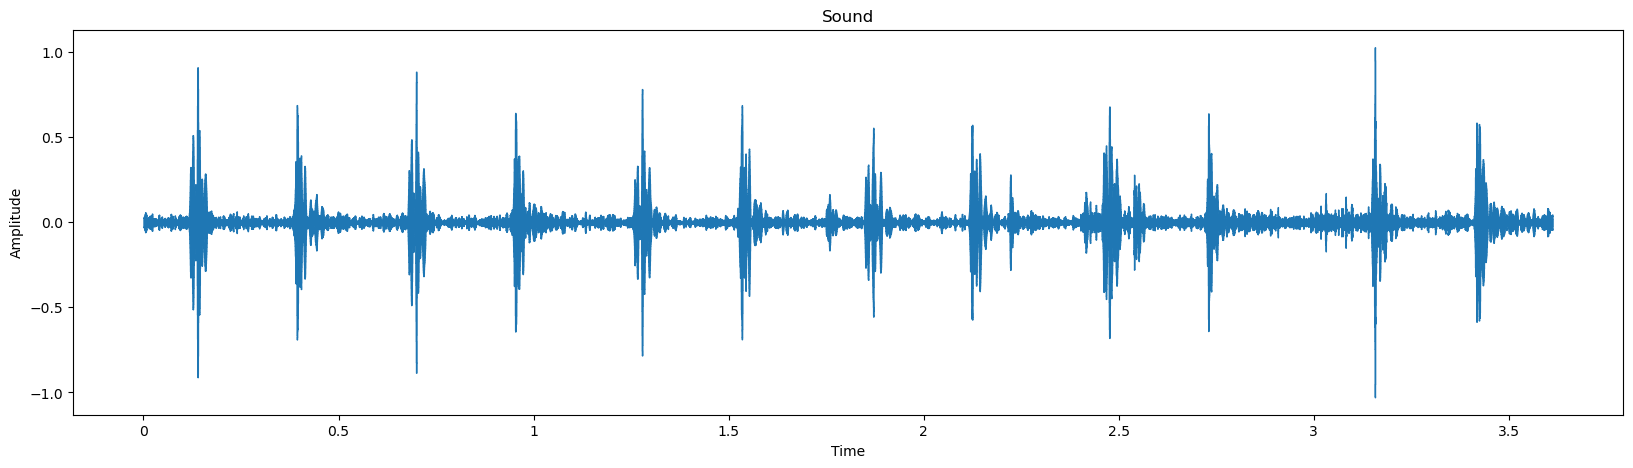

In [26]:
show_audio_waveform(extrastole_sample)

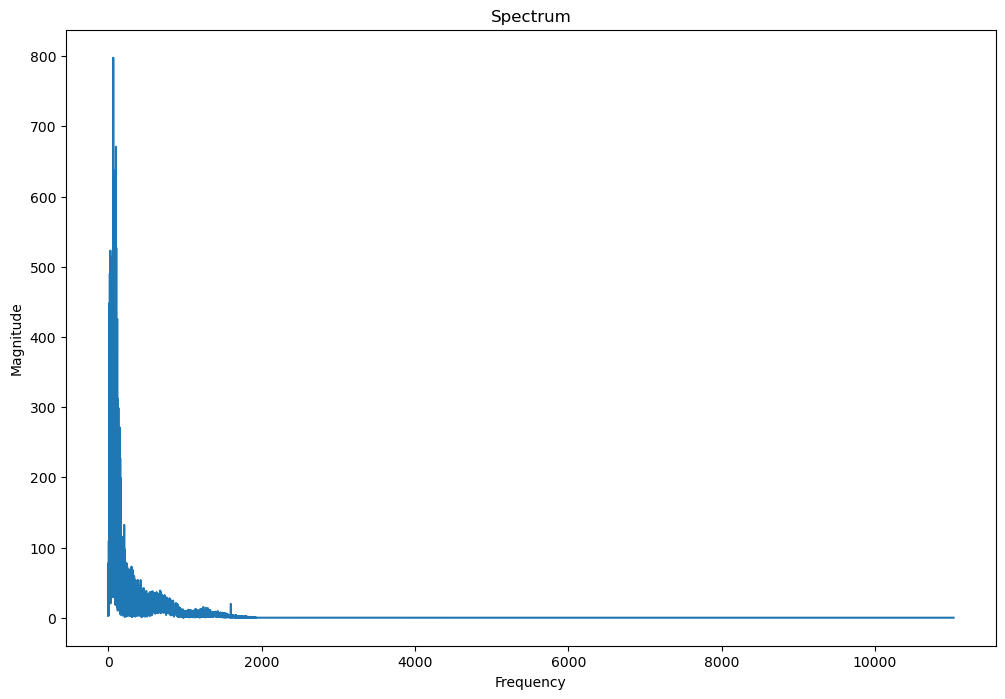

In [27]:
show_audio_spectrum(extrastole_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


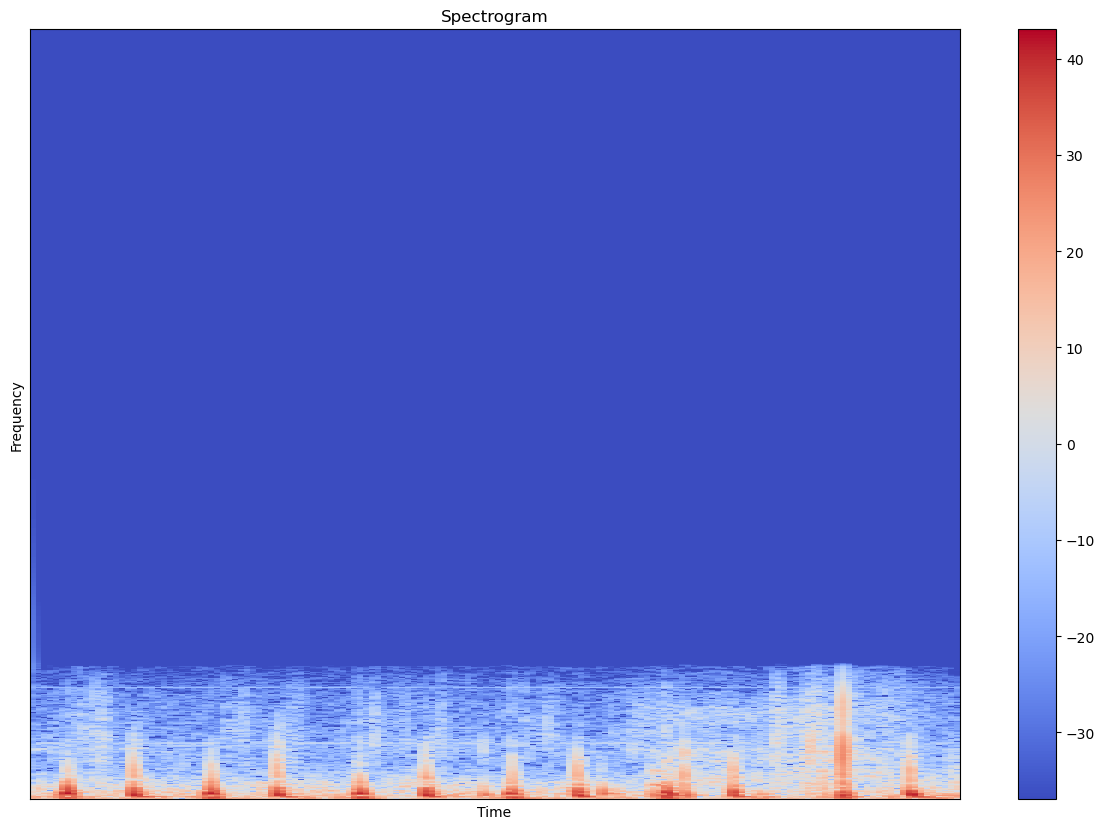

In [28]:
show_spectrogram(extrastole_sample)

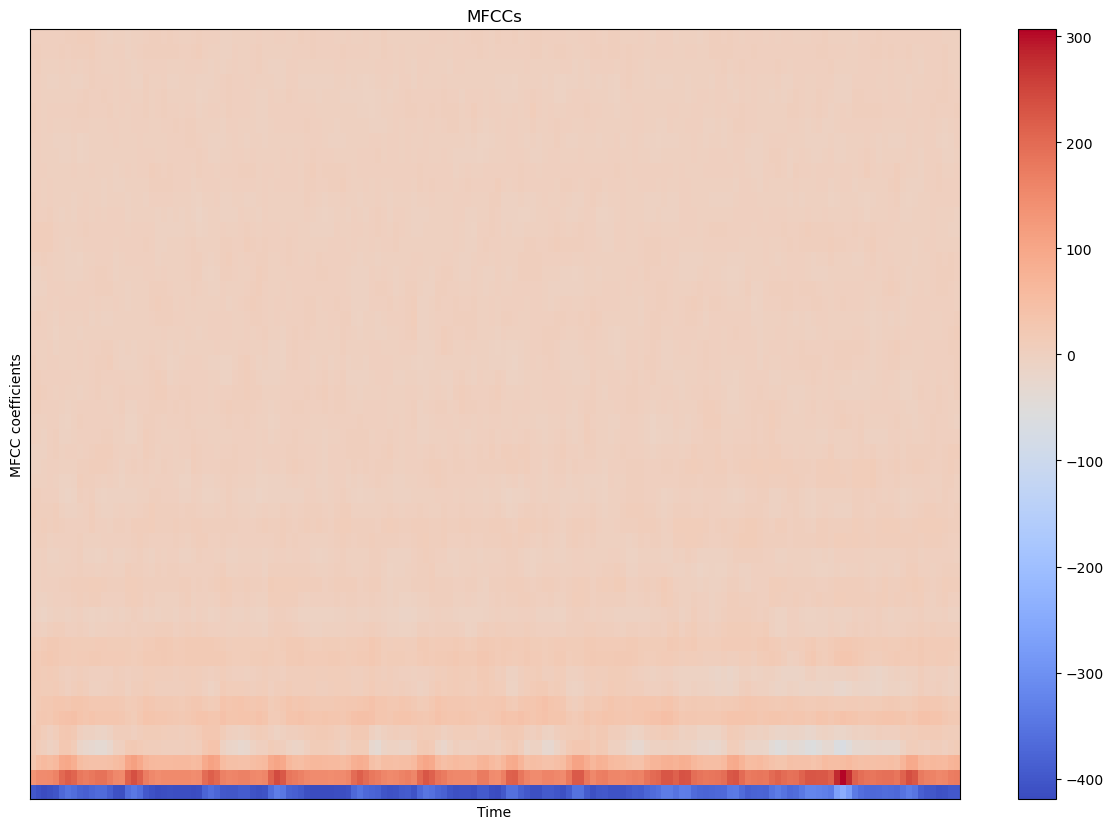

In [29]:
show_mfcc_features(extrastole_sample)

4. Artifact sound

• In the Artifact category there are a wide range of different
sounds, including feedback squeals and echoes, speech, music
and noise.

In [30]:
artifact_audio,artifact_sample=random_sound(artifact_data)
artifact_audio

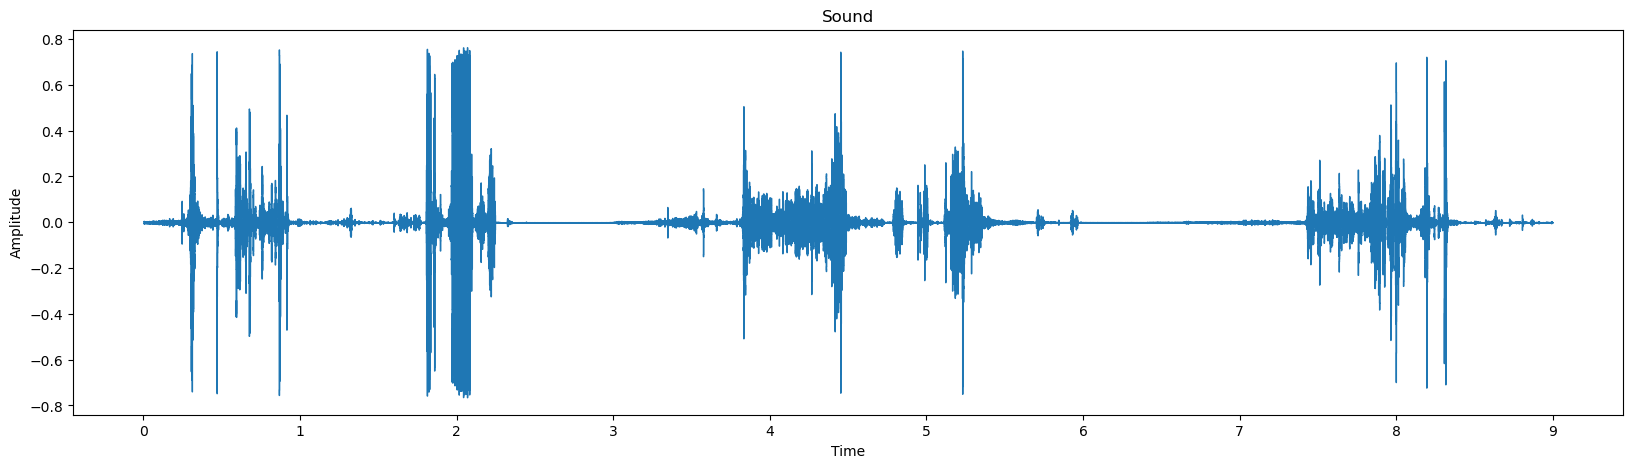

In [31]:
show_audio_waveform(artifact_sample)

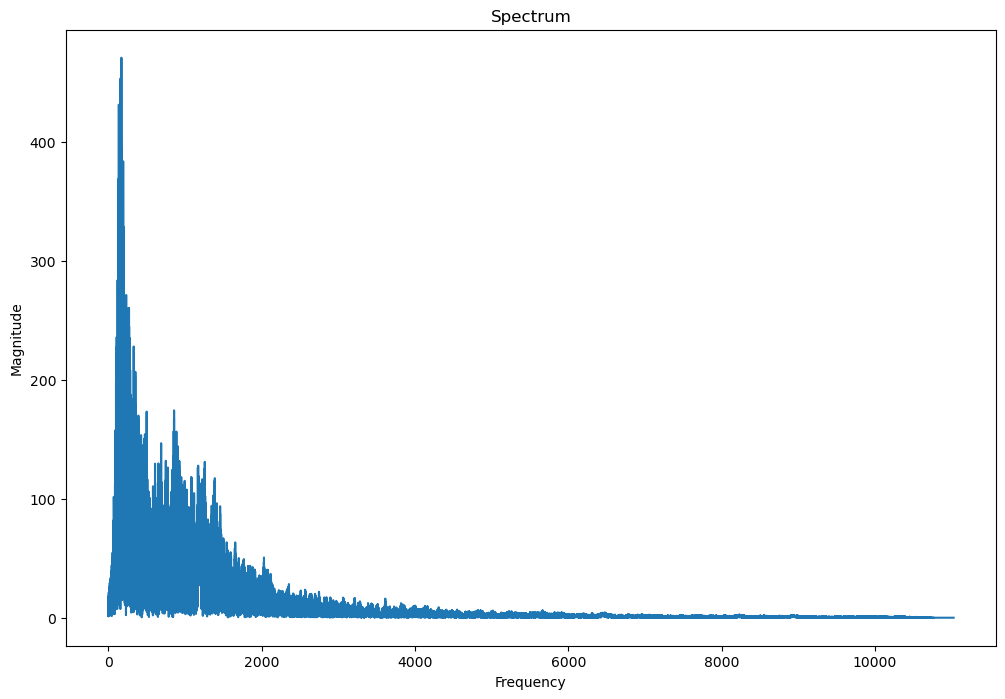

In [32]:
show_audio_spectrum(artifact_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


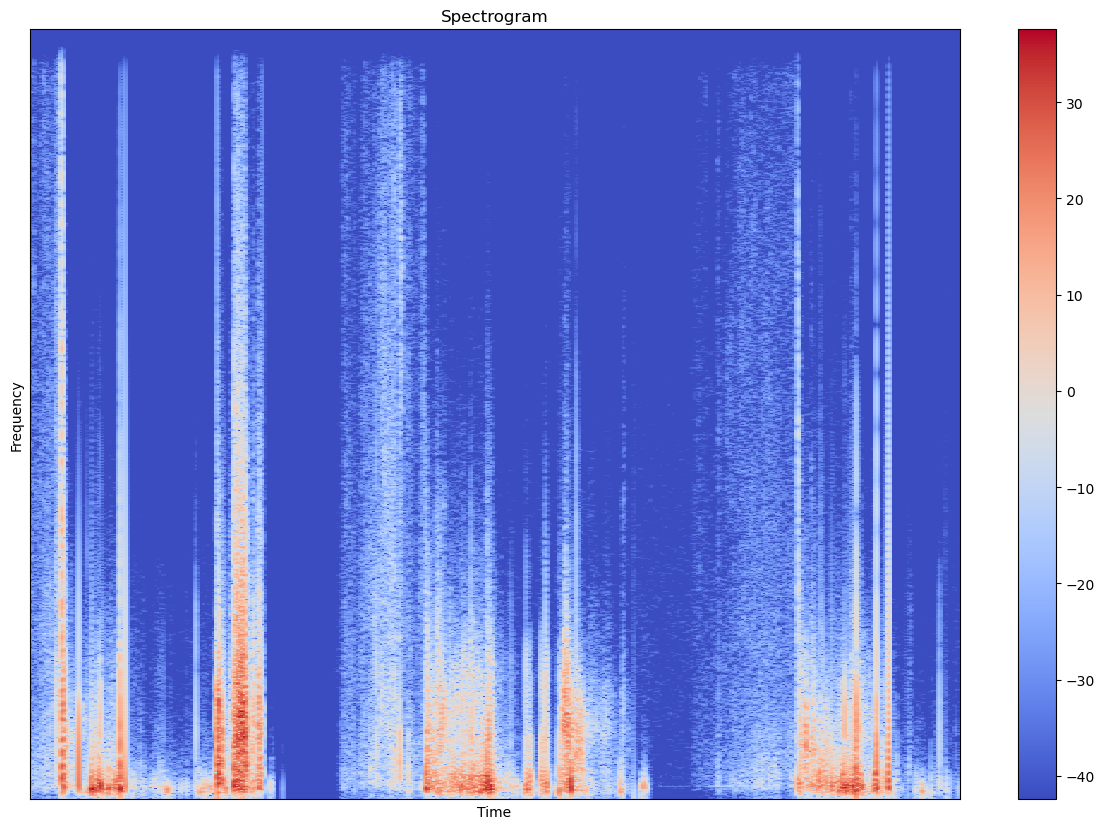

In [33]:
show_spectrogram(artifact_sample)

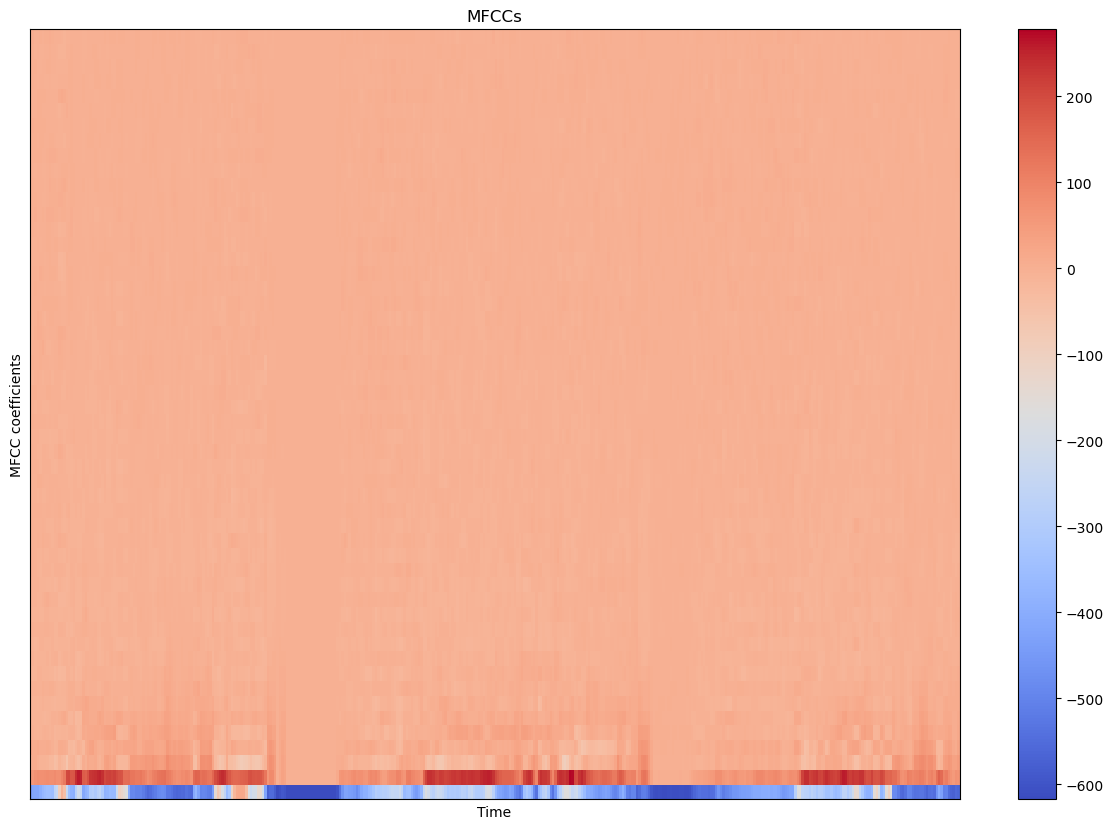

In [34]:
show_mfcc_features(artifact_sample)

5. Extrahls sound

Extra heart sounds can be identified because there is an
additional sound, e.g. a “lub-lub dub” or a “lub dub-dub”.

In [35]:
extrahls_audio,extrahls_sample=random_sound(extrahls_data)
extrahls_audio

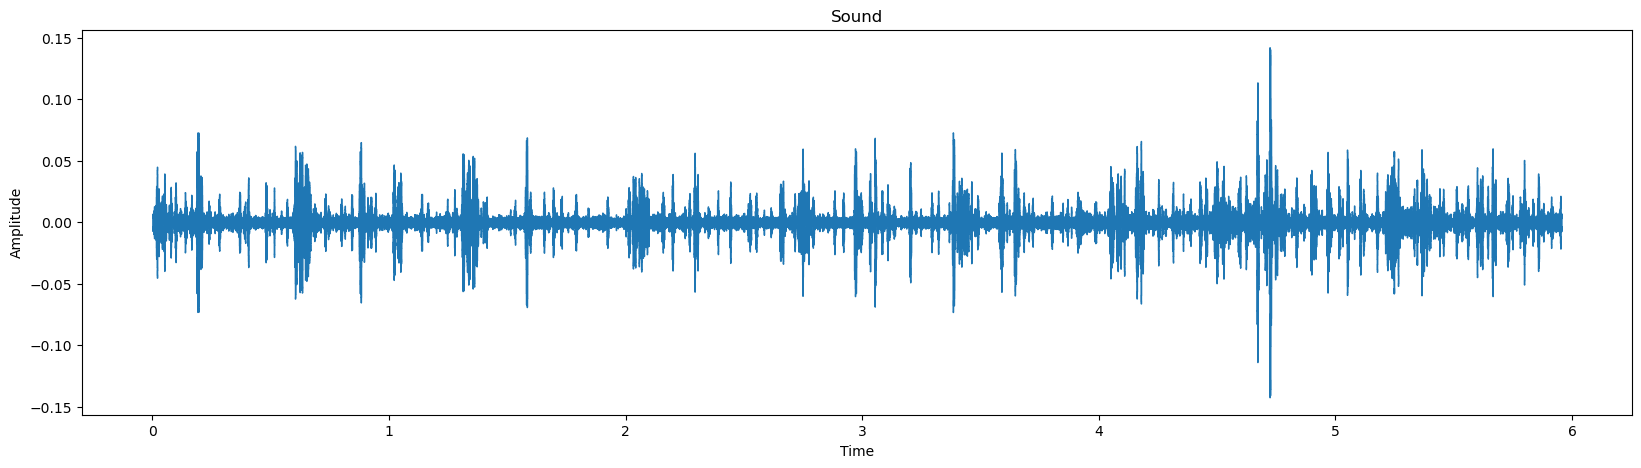

In [36]:
show_audio_waveform(extrahls_sample)

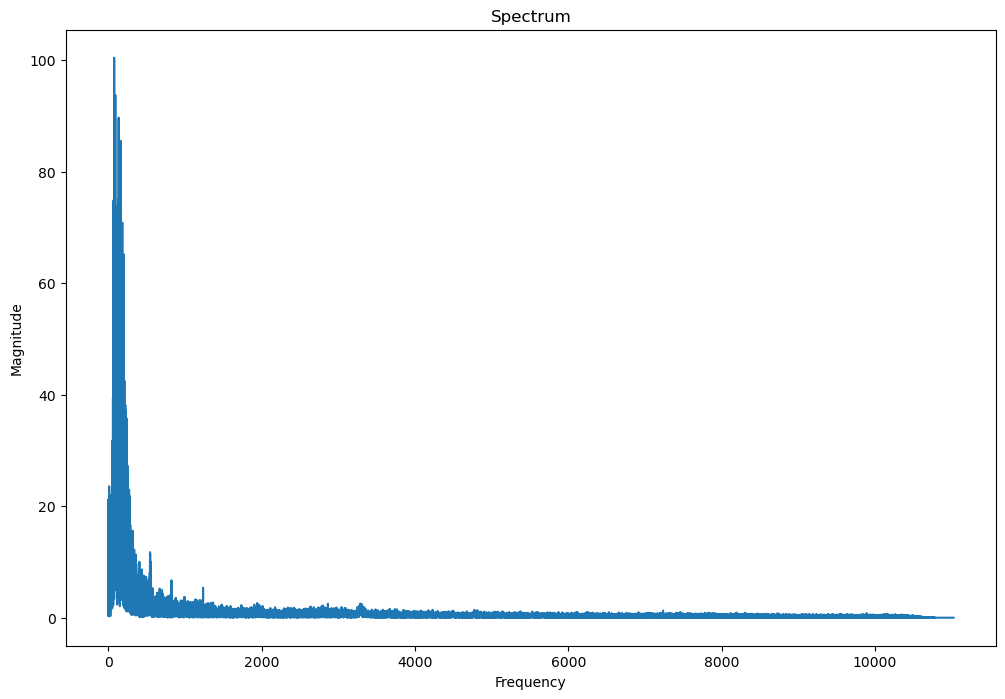

In [37]:
show_audio_spectrum(extrahls_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


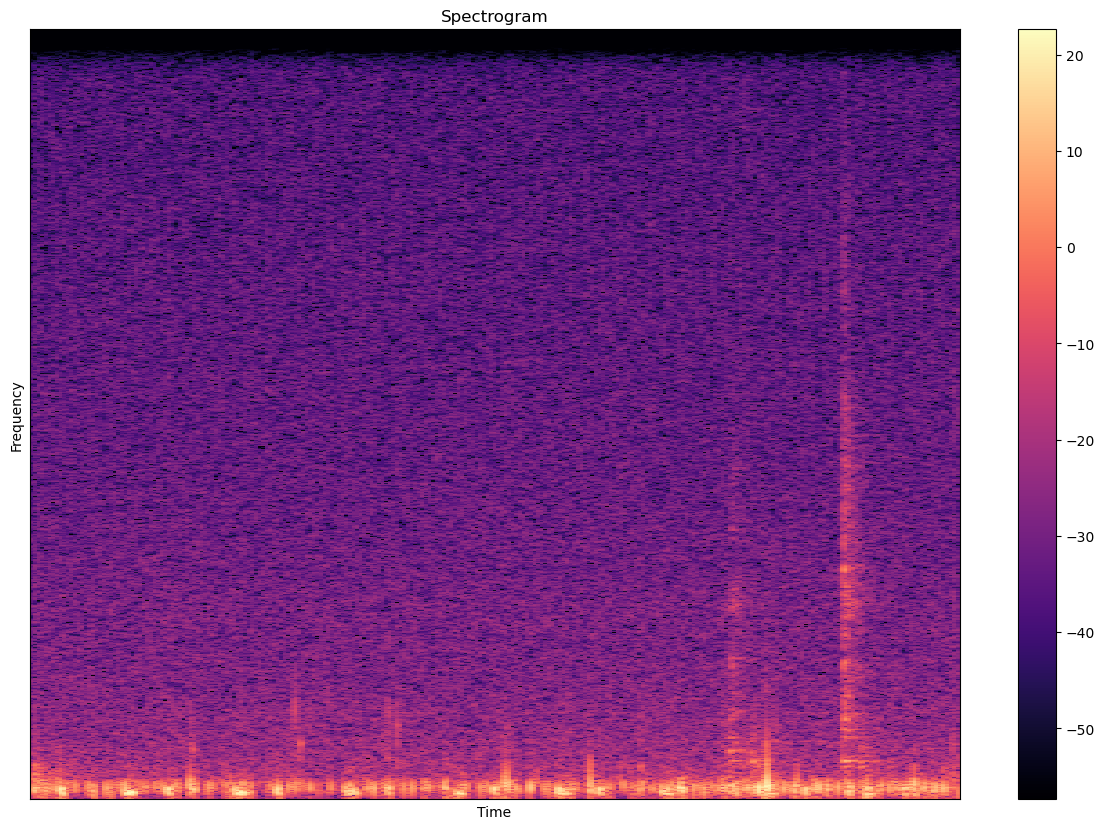

In [38]:
show_spectrogram(extrahls_sample)

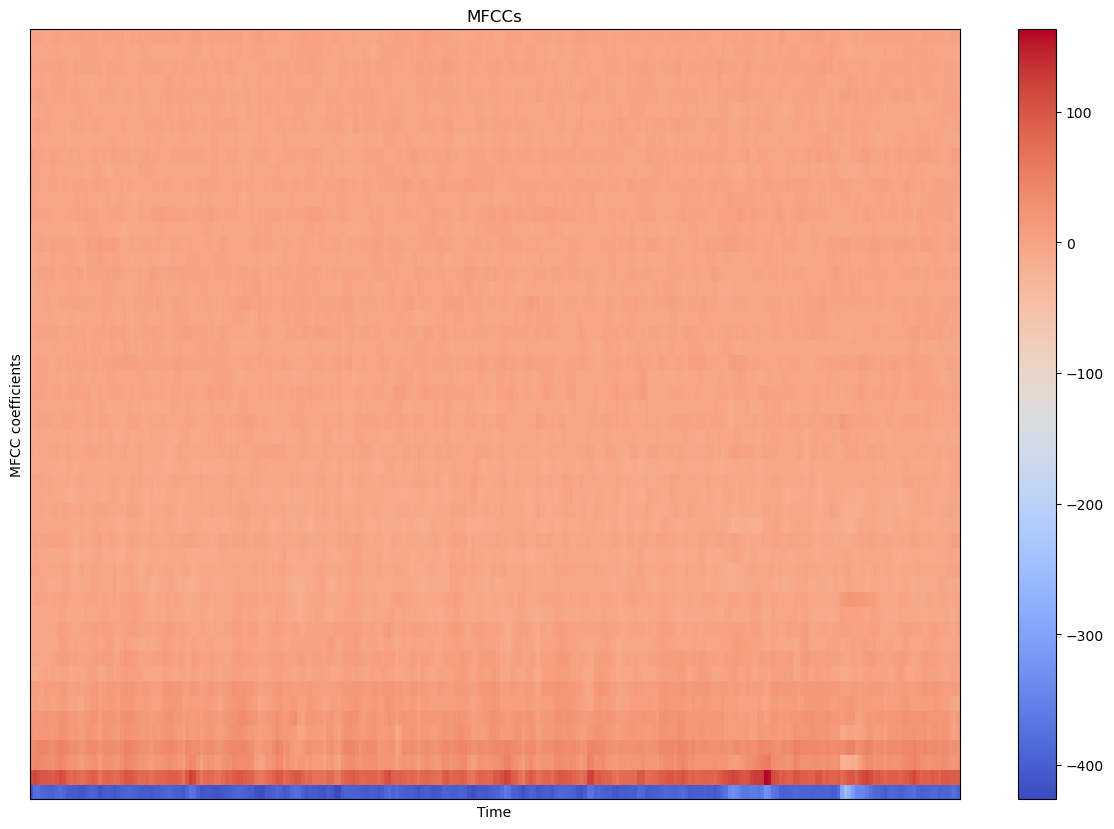

In [39]:
show_mfcc_features(extrahls_sample)

Data Preprocessing

In [40]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_shift(data, rate, sr=22050):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=rate)


In [41]:
def load_file_data(folder, file_names, duration=10, sr=22050):
    input_length = sr * duration
    features = 52
    data = []

    for file_name in file_names:
        try:
            sound_file = folder + file_name
            X, sr = librosa.load(sound_file, sr=sr, duration=duration)
            dur = librosa.get_duration(y=X, sr=sr)

            # pad audio file to same duration
            if round(dur) < duration:
                print("fixing audio length:", file_name)
                X = librosa.util.fix_length(data=X, size=input_length)

            # original MFCC
            mfccs = np.mean(librosa.feature.mfcc(
                y=X, sr=sr, n_mfcc=features).T, axis=0)
            data.append(mfccs.reshape([-1, 1]))

            # stretch 0.8
            stretch_1 = stretch(X, 0.8)
            mfcc_1 = np.mean(librosa.feature.mfcc(
                y=stretch_1, sr=sr, n_mfcc=features).T, axis=0)
            data.append(mfcc_1.reshape([-1, 1]))

            # stretch 1.2
            stretch_2 = stretch(X, 1.2)
            mfcc_2 = np.mean(librosa.feature.mfcc(
                y=stretch_2, sr=sr, n_mfcc=features).T, axis=0)
            data.append(mfcc_2.reshape([-1, 1]))

        except Exception as e:
            print("Error encountered while parsing file:", file_name, "=>", e)

    return data


In [42]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


Data Standardization and Feature Extraction

In [43]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

artifact_files=fnmatch.filter(os.listdir(artifact_data),'artifact*.wav')
artifact_sounds=load_file_data(folder=artifact_data,file_names=artifact_files,duration=MAX_SOUND_CLIP_DURATION)
artifact_labels = [0 for items in artifact_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), 'normal*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]

extrahls_files = fnmatch.filter(os.listdir(extrahls_data), 'extrahls*.wav')
extrahls_sounds = load_file_data(folder=extrahls_data,file_names=extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
extrahls_labels = [2 for items in extrahls_sounds]

murmur_files = fnmatch.filter(os.listdir(murmur_data), 'murmur*.wav')
murmur_sounds = load_file_data(folder=murmur_data,file_names=murmur_files, duration=MAX_SOUND_CLIP_DURATION)
murmur_labels = [1 for items in murmur_sounds]


extrastole_files = fnmatch.filter(os.listdir(extrastole_data), 'extrastole*.wav')
extrastole_sounds = load_file_data(folder=extrastole_data,file_names=extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
extrastole_labels = [2 for items in extrastole_sounds]

print ("Loading Done")

fixing audio length: artifact__201012172012.wav
fixing audio length: artifact__201105040918.wav
fixing audio length: artifact__201105041959.wav
fixing audio length: artifact__201105051017.wav
fixing audio length: artifact__201105060108.wav
fixing audio length: artifact__201105061143.wav
fixing audio length: artifact__201105190800.wav
fixing audio length: artifact__201105280851.wav
fixing audio length: artifact__201106010559.wav
fixing audio length: artifact__201106010602.wav
fixing audio length: artifact__201106021541.wav
fixing audio length: artifact__201106030612.wav
fixing audio length: artifact__201106031558.wav
fixing audio length: artifact__201106040722.wav
fixing audio length: artifact__201106040933.wav
fixing audio length: artifact__201106040947.wav
fixing audio length: artifact__201106041452.wav
fixing audio length: artifact__201106050353.wav
fixing audio length: artifact__201106061233.wav
fixing audio length: artifact__201106070537.wav
fixing audio length: artifact__201106070

In [44]:
print("\nClass-wise sample count (after loading / augmentation if applied):")
print(f"Artifact (label 0):    {len(artifact_labels)}")
print(f"Murmur   (label 1):    {len(murmur_labels)}")
print(f"Normal   (label 2):    {len(normal_labels)}")
print(f"Extrahls (label 2):    {len(extrahls_labels)}")
print(f"Extrastole (label 2):  {len(extrastole_labels)}")

total_samples = (
    len(artifact_labels) +
    len(murmur_labels) +
    len(normal_labels) +
    len(extrahls_labels) +
    len(extrastole_labels)
)

print(f"\nTotal samples: {total_samples}")



Class-wise sample count (after loading / augmentation if applied):
Artifact (label 0):    120
Murmur   (label 1):    387
Normal   (label 2):    1053
Extrahls (label 2):    57
Extrastole (label 2):  138

Total samples: 1755


In [45]:
# unlabel_datala files
Bunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Bunlabelledtest*.wav')
Bunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Bunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Bunlabelledtest_labels = [-1 for items in Bunlabelledtest_sounds]

Aunlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), 'Aunlabelledtest*.wav')
Aunlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=Aunlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
Aunlabelledtest_labels = [-1 for items in Aunlabelledtest_sounds]


print ("Loading of unlabel data done")


fixing audio length: Bunlabelledtest__101_1305030823364_F.wav
fixing audio length: Bunlabelledtest__103_1305031931979_A.wav
fixing audio length: Bunlabelledtest__103_1305031931979_C.wav
fixing audio length: Bunlabelledtest__106_1306776721273_B.wav
fixing audio length: Bunlabelledtest__106_1306776721273_D.wav
fixing audio length: Bunlabelledtest__107_1305654946865_B.wav
fixing audio length: Bunlabelledtest__109_1305653972028_B.wav
fixing audio length: Bunlabelledtest__109_1305653972028_D.wav
fixing audio length: Bunlabelledtest__112_1306243000964_C.wav
fixing audio length: Bunlabelledtest__113_1306244002866_C.wav
fixing audio length: Bunlabelledtest__117_1306262456650_B1.wav
fixing audio length: Bunlabelledtest__118_1306262335509_A.wav
fixing audio length: Bunlabelledtest__118_1306262335509_A1.wav
fixing audio length: Bunlabelledtest__118_1306262335509_C2.wav
fixing audio length: Bunlabelledtest__122_1306325762831_A.wav
fixing audio length: Bunlabelledtest__122_1306325762831_B.wav
fixin

In [46]:
print("\nUnlabelled test data summary:")

print(f"B-unlabelled test samples : {len(Bunlabelledtest_sounds)}")
print(f"A-unlabelled test samples : {len(Aunlabelledtest_sounds)}")

print("\nAssigned labels check (should be -1):")
print(f"B-unlabelled unique labels : {set(Bunlabelledtest_labels)}")
print(f"A-unlabelled unique labels : {set(Aunlabelledtest_labels)}")

print("\nTotal unlabelled test samples:")
print(len(Bunlabelledtest_sounds) + len(Aunlabelledtest_sounds))


Unlabelled test data summary:
B-unlabelled test samples : 585
A-unlabelled test samples : 156

Assigned labels check (should be -1):
B-unlabelled unique labels : {-1}
A-unlabelled unique labels : {-1}

Total unlabelled test samples:
741


Concatenation

In [47]:
#combine set-a and set-b
# sound files
x_data = np.concatenate((artifact_sounds, normal_sounds,extrahls_sounds,murmur_sounds,extrastole_sounds))
# contains labels
y_data = np.concatenate((artifact_labels, normal_labels,extrahls_labels,murmur_labels,extrastole_labels))

test_x = np.concatenate((Aunlabelledtest_sounds,Bunlabelledtest_sounds))
test_y = np.concatenate((Aunlabelledtest_labels,Bunlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  1755 741


Data Split

In [76]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

Correct Imbalanced Data

In [77]:
# class weight
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #artifact
COUNT_1 = 129 #murmur
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

LSTM MODEL

BUILD MODEL

In [79]:
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

def build_model(hp):

    model = keras.Sequential()

    # ---- Conv1D Layer ----
    model.add(layers.Conv1D(
        filters=hp.Int('conv_filters', min_value=32, max_value=2048, step=32),
        kernel_size=hp.Choice('kernel_size', values=[3,5,7]),
        strides=1,
        padding='same',
        activation='relu',
        input_shape=(52, 1)
    ))

    model.add(layers.MaxPooling1D(
        pool_size=hp.Choice('pool_size', values=[2, 3]),
        strides=2
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(
        filters=hp.Int('conv_filters_2', min_value=32, max_value=1024, step=32),
        kernel_size=hp.Choice('kernel_size_2', values=[3,5,7]),
        strides=1,
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling1D(
        pool_size=hp.Choice('pool_size_2', values=[2, 3]),
        strides=2
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(
        filters=hp.Int('conv_filters_3', min_value=32, max_value=512, step=32),
        kernel_size=hp.Choice('kernel_size_3', values=[3,5,7]),
        strides=1,
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling1D(
        pool_size=hp.Choice('pool_size_3', values=[2, 3]),
        strides=2
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(
        filters=hp.Int('conv_filters_3', min_value=32, max_value=512, step=32),
        kernel_size=hp.Choice('kernel_size_3', values=[3,5,7]),
        strides=1,
        padding='same',
        activation='relu'
    ))
    model.add(layers.MaxPooling1D(
        pool_size=hp.Choice('pool_size_3', values=[2, 3]),
        strides=2
    ))
    model.add(layers.BatchNormalization())

    # ---- LSTM Layer ----
    model.add(layers.LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
        return_sequences=False
    ))

    # ---- Dense Layers ----
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=128, step=64),
        activation='relu'
    ))

    model.add(layers.Dropout(
        rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    ))

    model.add(layers.Dense(len(CLASSES), activation='softmax'))
    optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)

    model.compile(
    optimizer = optimiser,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

    return model

Model Finetuning & Experiments:

for model1 and model2 in early stopping patience=10, for model3 and model4 taking patience=20

In [80]:
# Delete the tuner_dir to ensure a fresh start for Keras Tuner
!rm -rf tuner_dir

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir',
    project_name='conv1d_lstm'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[early_stop]
)

best_model = tuner.get_best_models(1)[0]

Trial 10 Complete [00h 03m 50s]
val_accuracy: 0.9219858050346375

Best val_accuracy So Far: 0.978723406791687
Total elapsed time: 00h 18m 48s


c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [81]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 1984)       │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 1984)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 1984)       │         7,936 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 640)        │     3,809,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 640)        │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 512)        │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 512)         │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,119,235 (27.16 MB)

 Trainable params: 7,111,939 (27.13 MB)

 Non-trainable params: 7,296 (28.50 KB)

In [82]:
for layer in best_model.layers:
    if isinstance(layer, tf.keras.layers.MaxPooling1D):
        print(layer.name, layer.get_config())


max_pooling1d {'name': 'max_pooling1d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': (2,), 'padding': 'valid', 'strides': (2,), 'data_format': 'channels_last'}
max_pooling1d_1 {'name': 'max_pooling1d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': (2,), 'padding': 'valid', 'strides': (2,), 'data_format': 'channels_last'}
max_pooling1d_2 {'name': 'max_pooling1d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': (2,), 'padding': 'valid', 'strides': (2,), 'data_format': 'channels_last'}
max_pooling1d_3 {'name': 'max_pooling1d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': (2,), 'padding'

In [83]:
best_model.save(
    "./best_model3.keras"
)


In [86]:
best_model3=load_model("./best_model3.keras")

c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [87]:
best_model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 1984)       │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 1984)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 1984)       │         7,936 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 640)        │     3,809,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 640)        │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 512)        │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 512)         │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,343,115 (81.42 MB)

 Trainable params: 7,111,939 (27.13 MB)

 Non-trainable params: 7,296 (28.50 KB)

 Optimizer params: 14,223,880 (54.26 MB)

In [74]:
best_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 320)        │        51,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 320)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 320)        │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 192)        │       184,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 192)         │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 192)         │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 192)         │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,565,131 (5.97 MB)

 Trainable params: 521,219 (1.99 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 1,042,440 (3.98 MB)

In [106]:
best_model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 864)        │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 864)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 864)        │         3,456 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 896)        │     2,323,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 896)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 896)        │         3,584 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 480)        │     1,290,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 480)         │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 480)         │       691,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 480)         │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 160)            │       410,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,216,715 (54.23 MB)

 Trainable params: 4,737,091 (18.07 MB)

 Non-trainable params: 5,440 (21.25 KB)

 Optimizer params: 9,474,184 (36.14 MB)

Train Model

In [88]:
history = best_model3.fit(x_train_lstm, y_train_lstm,
                         validation_data=(x_val_lstm, y_val_lstm),
                         batch_size=8, epochs=150,
                         class_weight=class_weight,callbacks = early_stop )

Epoch 1/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.8979 - loss: 0.2245 - val_accuracy: 0.8974 - val_loss: 0.2463
Epoch 2/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9105 - loss: 0.1722 - val_accuracy: 0.8974 - val_loss: 0.2525
Epoch 3/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9129 - loss: 0.1978 - val_accuracy: 0.9174 - val_loss: 0.2033
Epoch 4/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9145 - loss: 0.1683 - val_accuracy: 0.6268 - val_loss: 0.8940
Epoch 5/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9279 - loss: 0.1364 - val_accuracy: 0.8889 - val_loss: 0.2899
Epoch 6/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9113 - loss: 0.1630 - val_accuracy: 0.8946 - val_loss: 0.2800
Epoch 7/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9295 - loss: 0.1380 - val_accuracy: 0.9544 - val_loss: 0.1643
Epoch 8/150
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9232 - loss: 0.1522 -

In [90]:
# Delete the tuner_dir to ensure a fresh start for Keras Tuner
!rm -rf tuner_dir

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='tuner_dir',
    project_name='conv1d_lstm'
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras",   # saved to disk
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    callbacks=[early_stop]
)

best_model = tuner.get_best_models(1)[0]

Trial 10 Complete [00h 00m 59s]
val_accuracy: 0.9432623982429504

Best val_accuracy So Far: 0.9716312289237976
Total elapsed time: 00h 17m 53s


c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 48 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [91]:
best_model.save(
    "./best_model4.keras"
)


In [92]:
best_model4=load_model("./best_model4.keras")
best_model4.summary()

c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 52, 1248)       │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 26, 1248)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 1248)       │         4,992 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 576)        │     3,594,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 576)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 576)        │         2,304 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 13, 480)        │     1,935,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 480)         │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6, 480)         │     1,613,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 480)         │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 224)            │       631,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        28,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,451,659 (89.46 MB)

 Trainable params: 7,815,363 (29.81 MB)

 Non-trainable params: 5,568 (21.75 KB)

 Optimizer params: 15,630,728 (59.63 MB)

In [93]:
test_loss, test_acc = best_model4.evaluate(x_test, y_test)
print(test_acc)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9601 - loss: 0.1065
0.9601139426231384


In [101]:
history = best_model4.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=150,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=20,
            restore_best_weights=True
        )
    ]
)


Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9588 - loss: 0.1108 - val_accuracy: 0.9574 - val_loss: 0.1180
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9739 - loss: 0.0818 - val_accuracy: 0.9291 - val_loss: 0.1815
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.9786 - loss: 0.0640 - val_accuracy: 0.9362 - val_loss: 0.1654
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9778 - loss: 0.0685 - val_accuracy: 0.9007 - val_loss: 0.2955
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9802 - loss: 0.0569 - val_accuracy: 0.9574 - val_loss: 0.0977
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9747 - loss: 0.0659 - val_accuracy: 0.9078 - val_loss: 0.2126
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9770 - loss: 0.0754 - val_accuracy: 0.9504 - val_loss: 0.1500
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9826 - loss: 0.0513 - val_accu

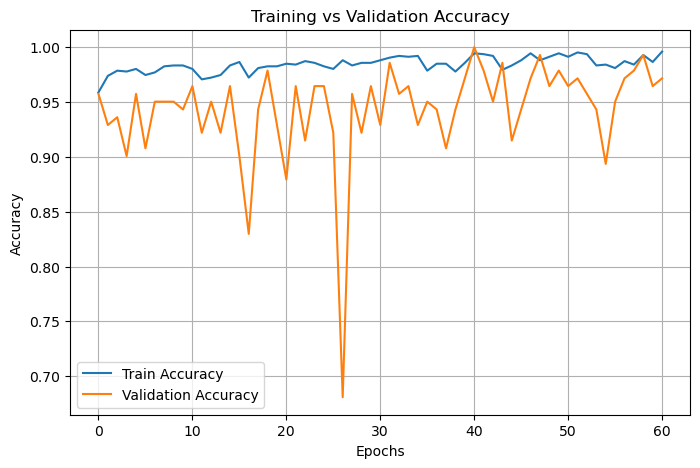

In [102]:


plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()


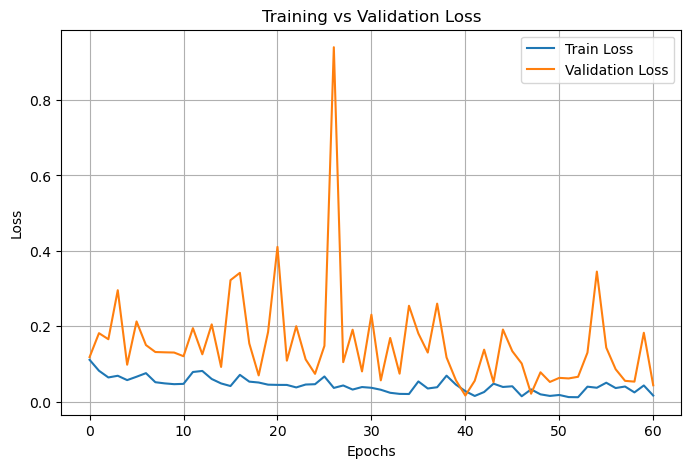

In [103]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()


In [97]:
test_loss, test_acc = best_model4.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9601 - loss: 0.1065
Test accuracy: 0.9601139426231384


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


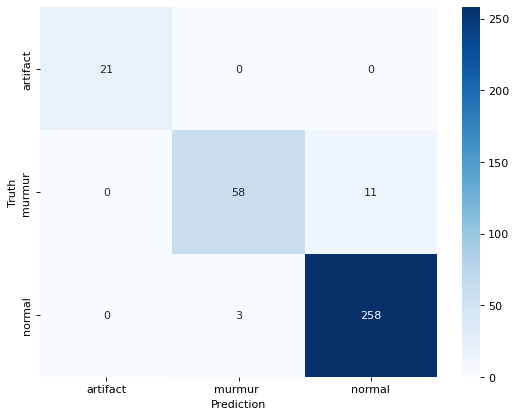

In [99]:
classes = ["artifact" ,"murmur ", "normal"]

preds = best_model4.predict(x_test)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [100]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00        21
     murmur        0.95      0.84      0.89        69
      normal       0.96      0.99      0.97       261

    accuracy                           0.96       351
   macro avg       0.97      0.94      0.96       351
weighted avg       0.96      0.96      0.96       351



In [107]:
final_model = best_model4
final_model.save("final_heart_murmur_model.keras")


best_model4 is performing best, so we're taking it as the final model

In [16]:
def heart_prediction(file_path, duration=10, sr=22050):
    classes = ["artifact", "murmur", "normal"]
    input_length = sr * duration

    # Load audio
    X, sr = librosa.load(file_path, sr=sr, duration=duration)
    dur = librosa.get_duration(y=X, sr=sr)

    # Fix length (new librosa API)
    if round(dur) < duration:
        X = librosa.util.fix_length(data=X, size=input_length)

    # Extract MFCC
    mfccs = np.mean(
        librosa.feature.mfcc(
            y=X,
            sr=sr,
            n_mfcc=52,
            n_fft=512,
            hop_length=2048
        ).T,
        axis=0
    )

    mfcc_input = mfccs.reshape(1, 52, 1)

    # Predict
    raw_pred = final_model.predict(mfcc_input)

    pred_class = classes[np.argmax(raw_pred)]
    confidence = float(np.max(raw_pred))

    return pred_class, confidence


PREDICTION:
Taking an unlabeled data from unlabel folder and predicting what type of heart_sound it is

In [137]:

file_path='E:\AI_PROJECT\Heart_Murmur_project\Aunlabelledtest__201108222254.wav'
pred, conf = heart_prediction(file_path)
print("Prediction:", pred)
print("Confidence:", conf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Prediction: murmur
Confidence: 0.816123902797699


In [23]:
file_path='E:\AI_PROJECT\Heart_Murmur_project\Bunlabelledtest__278_1311163365896_C.wav'
pred, conf = heart_prediction(file_path)
print("Prediction:", pred)
print("Confidence:", conf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: normal
Confidence: 0.9712057709693909


In [19]:
final_model=load_model(r"E:\AI_PROJECT\Heart_Murmur_project\best_model4.keras")

c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


let's see taking a sound from artifact and murmur if our model really predicts correctly

In [20]:

file_path2=r'E:\AI_PROJECT\Heart_Murmur_project\artifact__201106220340.wav'
pred, conf = heart_prediction(file_path2)
print("Prediction:", pred)
print("Confidence:", conf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Prediction: artifact
Confidence: 0.9981562495231628


In [22]:
file_path2=r'E:\AI_PROJECT\Heart_Murmur_project\murmur__171_1307971016233_D.wav'
pred, conf = heart_prediction(file_path2)
print("Prediction:", pred)
print("Confidence:", conf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction: murmur
Confidence: 0.9827074408531189


In [4]:
final_model=load_model(r"E:\AI_PROJECT\Heart_Murmur_project\best_model4.keras")
final_model.save("model.h5")

c:\Users\Urmi Kanrar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
